In [50]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sn
import time

In [4]:
#functions to execute randomized search

def getRandomizedSearch(model, param_grid, x_train, y_train):
    grid = RandomizedSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error',
                              n_iter=2, random_state=42, verbose=2, n_jobs=-1)
    grid.fit(x_train, y_train)
    print("Best Hyperparameters:", grid.best_params_)
    return grid

In [5]:
#functions to predict and check error

def predictAndGetError(model, x_valid, y_valid):
    y_pred = model.predict(x_valid)
    mse = mean_squared_error(y_valid, y_pred, squared=False)
    r2 = r2_score(y_valid, y_pred)
    print("RMSE  = ", mse)
    print("R-squared = ", r2)
    return mse, r2

In [6]:
train_df = pd.read_csv("/kaggle/input/playground-series-s3e11/train.csv", index_col='id')
test_df = pd.read_csv("/kaggle/input/playground-series-s3e11/test.csv", index_col='id')

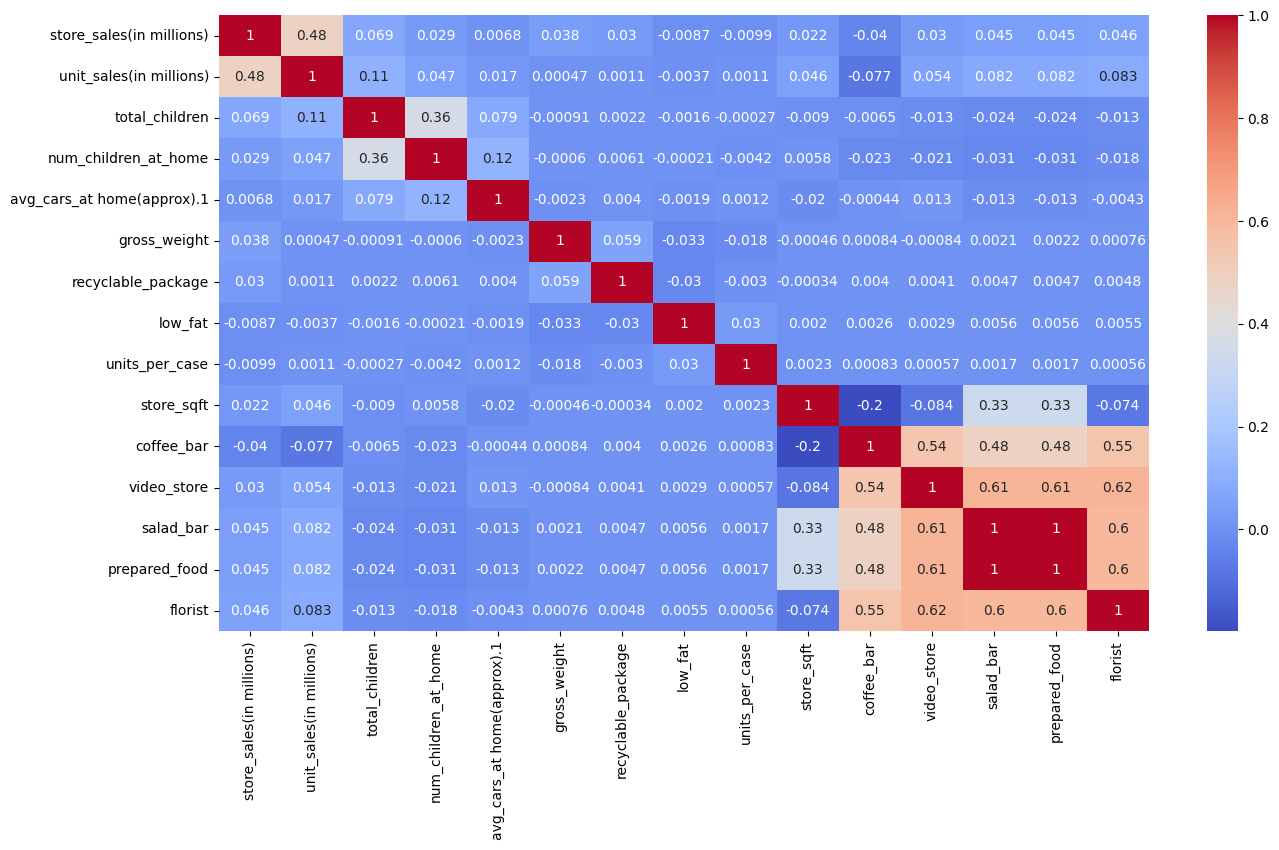

In [57]:
# Plot correlation matrix
columns = train_df.columns.tolist()
features = columns[:-1]
label = [columns[-1]]

X = train_df.loc[:, features]
y = train_df.loc[:, label]


correlation_matrix = X.corr()
plt.figure(figsize=(15, 8))
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


Only few features seems to significantly affect the cost. So, I selected the 8 most important features(selected salad_bar instead of prepared_food due to high correlation)

In [8]:
most_important_features = ['total_children', 'num_children_at_home',
                           'avg_cars_at home(approx).1', 'store_sqft',
                           'coffee_bar', 'video_store', 'salad_bar', 
                           'florist']

In [9]:
tg = train_df.groupby(most_important_features).cost.agg(['mean', 'count']).sort_values('count').reset_index()


In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(tg[most_important_features + ['count']], tg['mean'], random_state=0, train_size = .75)

In [11]:
X_test = test_df[most_important_features]

In [22]:
y_train = y_train.values.ravel()
y_valid = y_valid.values.ravel()
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(2295, 9)
(765, 9)
(240224, 8)


# **Model 1 - CatBoot Regressor**

In [36]:
model_cat = CatBoostRegressor(iterations=50,  # Number of trees (you can adjust this)
                         learning_rate=0.01,  # Learning rate (you can adjust this)
                         depth=6)

model_cat.fit(X_train[most_important_features], y_train,  sample_weight=X_train['count'])


0:	learn: 11.6620308	total: 54.3ms	remaining: 2.66s
1:	learn: 11.6459028	total: 55.6ms	remaining: 1.33s
2:	learn: 11.6352959	total: 56.4ms	remaining: 883ms
3:	learn: 11.6163425	total: 57.1ms	remaining: 656ms
4:	learn: 11.5931057	total: 57.8ms	remaining: 520ms
5:	learn: 11.5897824	total: 58.3ms	remaining: 427ms
6:	learn: 11.5737667	total: 59ms	remaining: 363ms
7:	learn: 11.5735847	total: 59.5ms	remaining: 313ms
8:	learn: 11.5551312	total: 60.3ms	remaining: 275ms
9:	learn: 11.5490403	total: 60.9ms	remaining: 244ms
10:	learn: 11.5260341	total: 61.6ms	remaining: 219ms
11:	learn: 11.5018362	total: 62.3ms	remaining: 197ms
12:	learn: 11.4919745	total: 62.8ms	remaining: 179ms
13:	learn: 11.4890282	total: 63.5ms	remaining: 163ms
14:	learn: 11.4730259	total: 64.3ms	remaining: 150ms
15:	learn: 11.4560913	total: 65.1ms	remaining: 138ms
16:	learn: 11.4511890	total: 65.9ms	remaining: 128ms
17:	learn: 11.4424225	total: 66.5ms	remaining: 118ms
18:	learn: 11.4376397	total: 67.3ms	remaining: 110ms
19:	l

In [37]:
mse_cat, r2_cat = predictAndGetError(model_cat, X_valid[most_important_features], y_valid)

RMSE  =  21.73531275593836
R-squared =  0.006666716162005537


In [ ]:
# # Define the parameter grid
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'mx_depth': [6, 8, 10, 12],
#     'iterations': [100, 500,100,4000],
#     'l2_leaf_reg': [1, 3, 5],
#     'boost_from_average': [True, False]
# }

# random_search_catbost = getRandomizedSearch(model_cat, param_grid, X_train, y_train)

# # Get the best hyperparameters and the corresponding model
# best_model_cat = random_search_catbost.best_estimator_

In [52]:
best_model_cat = CatBoostRegressor(n_estimators= 4000,
             max_depth= 12,
             learning_rate=0.1,
             verbose= False,
             boost_from_average= True, )

best_model_cat.fit(X_train[most_important_features], y_train,  sample_weight=X_train['count'])

In [53]:
mse_cat, r2_cat = predictAndGetError(best_model_cat, X_valid[most_important_features], y_valid)

RMSE  =  16.655361646427988
R-squared =  0.4167277233882368


# **Model 2 - XGBoost Regressor**

In [48]:
# Define the XGBoost Regressor model
model_xgb = xgb.XGBRegressor(
    learning_rate=0.1,  # Learning rate (also called eta)
    n_estimators=100,   # Number of boosting rounds (trees)
    max_depth=3,        # Maximum depth of each tree
    objective='reg:squarederror',  # Objective for regression
    random_state=42     # Random seed for reproducibility
)

In [49]:
model_xgb.fit(X_train[most_important_features], y_train, sample_weight=X_train['count'])

mse_xgb, r2_xgb = predictAndGetError(model_xgb, X_valid[most_important_features], y_valid)

RMSE  =  19.020870002870478
R-squared =  0.23928154032119897


# **Model 3 - ExtraTrees Regressor**

In [23]:
model_ET = ExtraTreesRegressor(
    n_estimators=100,   # Number of trees in the ensemble
    max_depth=None,      # Maximum depth of each tree (or None for full tree expansion)
    random_state=42      # Random seed for reproducibility
)

model_ET.fit(X_train[most_important_features], y_train,  sample_weight=X_train['count'])
mse_ET, r2_ET = predictAndGetError(model_ET, X_valid[most_important_features], y_valid)

RMSE  =  18.019814717734285
R-squared =  0.31724664554104


# **Model 4 - Random Forest Regressor**

In [56]:
model_rf = RandomForestRegressor(bootstrap=False, max_features=6, n_estimators=400,
                                min_weight_fraction_leaf=4.5/360336, random_state=44)

model_rf.fit(X_train[most_important_features], y_train,  sample_weight=X_train['count'])
mse_rf, r2_rf = predictAndGetError(model_rf, X_valid[most_important_features], y_valid)

RMSE  =  17.259042076324256
R-squared =  0.3736795743036647


# **Model 1 - LightGBM Regressor**

In [55]:
lgb_model = lgb.LGBMRegressor(learning_rate = 0.1,
    n_estimators= 450,
    num_leaves=100,
    min_child_samples= 1,
    min_child_weight= 1e1,
    random_state=1
     )

lgb_model.fit(X_train[most_important_features], y_train,  sample_weight=X_train['count'])
mse_lgb, r2_gb = predictAndGetError(lgb_model, X_valid[most_important_features], y_valid)

RMSE  =  16.4108694376294
R-squared =  0.43372631424021435


Model developed with Light Gradient Boosting Machine gives the best performance. So the test set will be predicted using this model 

In [58]:
#get the originl test set
test_df_original = pd.read_csv("/kaggle/input/playground-series-s3e11/test.csv")

#Predict on test set with LightGBM model
y_pred_lgb = lgb_model.predict(X_test)
result_df = pd.DataFrame({'id': test_df_original['id'], 'cost': y_pred_lgb})
result_df.to_csv("solutions_final.csv", index=False)   